# Policy analysis
The point of this notebook is to analyze the privacy policies fetched with the spider.  
This presumes all the policies that are marked as successfully gathered in the report file are good, and only looks at said policies

In [2]:
import os
import json
import justext
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

## 1 Overview

In [3]:
DATADIR = "data/"
POLICY_FILE_PREFIX = "policy_"
REPORT_FILE_NAME = "crawl_report.json"

In [4]:
report_json = pd.read_json(DATADIR + REPORT_FILE_NAME)
report_json

,url,policy_domain,policy_url,policy_file,uses_iubenda,success
0,https://www.corriere.it/,www.corriere.it,https://www.corriere.it/privacy.shtml,policy_www.corriere.it.txt,False,True
1,https://www.gazzetta.it/,www.gazzetta.it,https://www.gazzetta.it/privacy.shtml,policy_www.gazzetta.it.txt,False,True
2,https://www.repubblica.it/,None,None,policy_www.repubblica.it.txt,True,False
3,https://www.ansa.it/,www.ansa.it,https://www.ansa.it/sito/static/privacy.html,policy_www.ansa.it.txt,True,True
4,https://www.wikipedia.org/,meta.wikimedia.org,https://meta.wikimedia.org/wiki/Privacy_policy,policy_www.wikipedia.org.txt,False,True
...,...,...,...,...,...,...
79,https://www.dailyfx.com/,www.dailyfx.com,https://www.dailyfx.com/cookies,policy_www.dailyfx.com.txt,False,True
80,https://www.treccani.it/,www.treccani.it,https://www.treccani.it/footer/cookies.html,policy_www.treccani.it.txt,False,True
81,https://www.formulapassion.it/,www.formulapassion.it,https://www.formulapassion.it/privacy/,policy_www.formulapassion.it.txt,False,True
82,https://www.paypal.com/it/home,www.paypal.com,https://www.paypal.com/privacy-center,policy_www.paypal.com.txt,False,True


### 1.1 Success rate

In [5]:
# Recap
number_total = len(report_json)
print("Analyzed sites: " + str(number_total))

successful = report_json.loc[report_json["success"] == True]
number_successful = len(successful)
print("Successfully downloaded: " + str(number_successful))

print("Success rate: " + str(round((100 * number_successful / number_total), 1)) + "%")

failed_with_url = report_json.loc[pd.notna(report_json["policy_url"])
                                  & (report_json["success"] == False)]
print("Policy url found but no good policy found: " + str(len(failed_with_url)))
failed_with_url

Analyzed sites: 84
Successfully downloaded: 64
Success rate: 76.2%
Policy url found but no good policy found: 0


,url,policy_domain,policy_url,policy_file,uses_iubenda,success


### 1.2 Sites overview

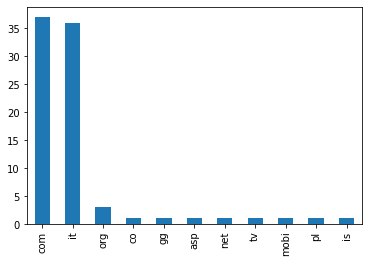

In [40]:
# TLDs

urls = report_json["url"]
ul = urls.tolist()

tlds = {}
for url in ul:
    tld = ((url.split(".")[len(url.split(".")) - 1]).split("/")[0]).split(":")[0]
    if tld in tlds.keys():
        tlds[tld] = tlds[tld] + 1
    else:
        tlds[tld] = 1
        
pd.Series(tlds).sort_values(ascending = False).plot.bar()
plt.show()

## 2 Simple analysis
### 2.1 Wordcounts

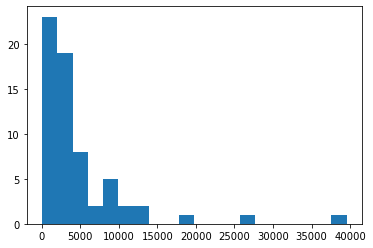

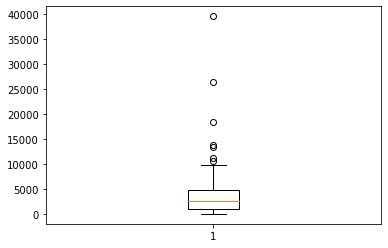

In [6]:
# Simple analysis i.e. wordcount
# Open policy files
policy_file_names = successful["policy_file"].tolist()

policy_files = []
for filename in policy_file_names:
    policy_files.append(open(DATADIR + filename))


wordcounts = []
for file in policy_files:
    wordcounts.append(len(file.read().split()))

plt.hist(wordcounts, 20)
plt.show()
plt.boxplot(wordcounts)
plt.show()

### 2.2 Wordclouds

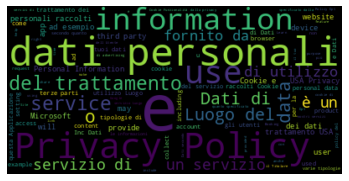

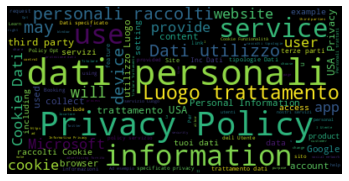

In [7]:
# Some fun wordclouds :)
policy_files = []
for filename in policy_file_names:
    policy_files.append(open(DATADIR + filename))

all_policy_text = ""
for file in policy_files:
    all_policy_text += file.read()

wordcloud = WordCloud().generate(all_policy_text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Unsurprisingly you have to filter out heaps of words...
policy_files = []
for filename in policy_file_names:
    policy_files.append(open(DATADIR + filename))

all_policy_text_filtered = ""
for file in policy_files:
    for word in file.read().split():
        if word not in (justext.get_stoplist("Italian")):
            all_policy_text_filtered += word + " "

wordcloud = WordCloud().generate(all_policy_text_filtered)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### 2.3 Emotion analysis

In [10]:
# Text2Emotion
import text2emotion as t2e
import emoji
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /home/user/nltk_data...


True

In [28]:
emotions_dict = {
    "Angry" : 0,
    "Fear" : 0,
    "Happy" : 0,
    "Sad" : 0,
    "Surprise" : 0
}

In [37]:
policy_files = []
for filename in policy_file_names:
    policy_files.append(open(DATADIR + filename))

In [29]:
for file in policy_files:
    emotions = t2e.get_emotion(file.read())
    top_emotion = max(emotions)
    emotions_dict[top_emotion] = emotions_dict[top_emotion] + 1

emotions_dict

{'Angry': 0, 'Fear': 0, 'Happy': 0, 'Sad': 0, 'Surprise': 61}

In [38]:
emotions_dict = {
    "Angry" : 0,
    "Fear" : 0,
    "Happy" : 0,
    "Sad" : 0,
    "Surprise" : 0
}

for file in policy_files:
    emotions = t2e.get_emotion(file.read())
    for emotion in emotions:
        emotions_dict[emotion] = emotions_dict[emotion] + emotions[emotion] # maybe normalize?

emotions_dict

{'Angry': 1.5100000000000007,
 'Fear': 38.690000000000005,
 'Happy': 6.3900000000000015,
 'Sad': 10.309999999999999,
 'Surprise': 4.11}

In [ ]:
# Kinda underwhelming...

In [34]:
emotions_dict = {
    "Angry" : 0,
    "Fear" : 0,
    "Happy" : 0,
    "Sad" : 0,
    "Surprise" : 0
}

emotions = {
    "Angry" : 1,
    "Fear" : 2,
    "Happy" : 7,
    "Sad" : 1,
    "Surprise" : 3
}

for emotion in emotions:
    print(emotions[emotion])

1
2
7
1
3
